In [1]:
import torch
import torch.nn.functional as F
import math
from torch.autograd import Variable

In [28]:
class FunLSQ(torch.autograd.Function):
    @staticmethod
    def forward(ctx, weight, alpha, g, Qn, Qp):
        assert alpha > 0, 'alpha = {}'.format(alpha)
        ctx.save_for_backward(weight, alpha)
        ctx.other = g, Qn, Qp
        q_w = (weight / alpha).round().clamp(Qn, Qp)
        w_q = q_w * alpha
        return w_q

    @staticmethod
    def backward(ctx, grad_weight):
        weight, alpha = ctx.saved_tensors
        g, Qn, Qp = ctx.other
        q_w = weight / alpha
        indicate_small = (q_w < Qn).float()
        indicate_big = (q_w > Qp).float()
        indicate_middle = torch.ones(indicate_small.shape).to(indicate_small.device) - indicate_small - indicate_big
        grad_alpha = ((indicate_small * Qn + indicate_big * Qp + indicate_middle * (
                -q_w + q_w.round())) * grad_weight * g).sum().unsqueeze(dim=0)
        grad_weight = indicate_middle * grad_weight
        # The following operation can make sure that alpha is always greater than zero in any case and can also
        # suppress the update speed of alpha. (Personal understanding)
#         grad_alpha.clamp_(-alpha.item(), alpha.item())  # FYI
        return grad_weight, grad_alpha, None, None, None

In [3]:
def grad_scale(x, scale):
    y = x
    y_grad = x * scale
    return y.detach() - y_grad.detach() + y_grad

def round_pass(x):
    y = x.round()
    y_grad = x
    return y.detach() - y_grad.detach() + y_grad

## Initialize the variables

In [23]:
nbits = 4
Qn = -2 ** (nbits - 1)
Qp = 2 ** (nbits - 1) - 1
# g = math.sqrt(weight.numel() * Qp)
g = 1.0/2

## Method1 accroding to the LSQ paper:

In [24]:
ws = []
wqs = []
alpha_grads = []
for i in range(1000):
    weight = Variable(torch.Tensor([i * 0.01]), requires_grad=True)
    alpha = torch.ones(1, requires_grad=True)
    ws.append(weight.data[0])
    alpha2 = grad_scale(alpha, g)
    w = weight / alpha2
    w = w.clamp(Qn, Qp)
    q_w = round_pass(w)
    w_q = q_w * alpha2
    wqs.append(w_q.data[0])
    w_q.backward()
    alpha_grads.append(alpha.grad)
# print(ws)
# print(wqs)
# print(alpha_grads)

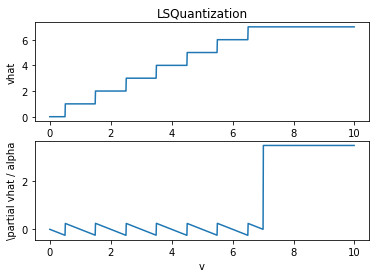

In [25]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting

plt.subplot(2, 1, 1)

plt.plot(ws, wqs)
plt.title('LSQuantization')
plt.ylabel('vhat')

plt.subplot(2, 1, 2)

plt.plot(ws, alpha_grads)
plt.ylabel('\partial vhat / alpha')
plt.xlabel('v')

plt.show()

## Method2:

In [29]:
ws = []
wqs = []
alpha_grads = []
for i in range(1000):
    weight = Variable(torch.Tensor([i * 0.01]), requires_grad=True)
    alpha = torch.ones(1, requires_grad=True)
    ws.append(weight.data[0])
    w_q = FunLSQ.apply(weight, alpha, g, Qn, Qp)
    wqs.append(w_q.data[0])
    w_q.backward(retain_graph=True)
    alpha_grads.append(alpha.grad)


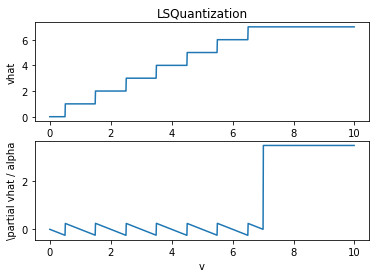

In [30]:
plt.subplot(2, 1, 1)

plt.plot(ws, wqs)
plt.title('LSQuantization')
plt.ylabel('vhat')

plt.subplot(2, 1, 2)

plt.plot(ws, alpha_grads)
plt.ylabel('\partial vhat / alpha')
plt.xlabel('v')

plt.show()